## Import Libraries


In [2]:
import pandas as pd
import os
import json

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

!pip install langdetect
from langdetect import detect

import re
import requests
import spacy
from tqdm import tqdm

import ast
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=b72a7de04ecc7b0120e5301602647ffbf8ffe8f52aa2eba28efd47756e5589d7
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [3]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

Load all json files in one df (for further processing)

In [ ]:
# to load dataframes from google drive
df = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_uncleaned.csv')
df_reviews = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_uncleaned.csv')

In [ ]:
# look at number of reviews & Airbnbs
print("Number of uncleaned Airbnbs: ", len(df))
print("Number of uncleaned Reviews: ", len(df_reviews))

Number of uncleaned Airbnbs:  16106
Number of uncleaned Reviews:  1077494


## Data Cleaning

### Check & remove Duplicates

Airbnbs & Reviews: Numbers of Duplicates

In [ ]:
# Check if there are rows with the same URL
duplicate_urls = df.duplicated(subset='url', keep='first')

# Count the duplicate rows (excluding the first occurrence)
count_duplicate_urls = sum(duplicate_urls)

# Print the number of duplicate rows
print("Number of duplicate Airbnbs:", count_duplicate_urls)



# Check if there are rows with the same review ID
duplicate_ids = df_reviews.duplicated(subset='review_id', keep='first')

# Count the duplicate rows (excluding the first occurrence)
count_duplicate_ids = sum(duplicate_ids)

# Print the number of duplicate rows
print("Number of duplicate Reviews:", count_duplicate_ids)

Number of duplicate Airbnbs: 1531
Number of duplicate Reviews: 50734


Reviews: Look at some duplicates

In [ ]:
# Check manually some of the found duplicates -> seem to really be duplicates
duplicate_rows = df_reviews.duplicated(subset='review_id', keep=False) # Get a boolean mask for all duplicate rows (including the first occurrence)

# Get all duplicate rows
duplicates = df_reviews[duplicate_rows]

# Sort duplicates by 'review_id'
duplicates_sorted = duplicates.sort_values(by='review_id')

# Print the first 2 pairs of duplicate rows
print(duplicates_sorted.head(4))

                                         review_comments  \
97415  Thank you Jeanette.  The location was safe and...   
95495  Thank you Jeanette.  The location was safe and...   
97414  The apartment was fantastic -  spacious and fu...   
95494  The apartment was fantastic -  spacious and fu...   

           review_createdAt  review_id  review_rating review_localizedDate  \
97415  2010-08-11T16:36:23Z    76908.0            0.0          August 2010   
95495  2010-08-11T16:36:23Z    76908.0            0.0          August 2010   
97414  2010-08-30T15:50:12Z    87251.0            5.0          August 2010   
95494  2010-08-30T15:50:12Z    87251.0            5.0          August 2010   

       review_author.id review_language review_localizedReview.disclaimer  \
97415          169645.0             NaN                               NaN   
95495          169645.0             NaN                               NaN   
97414          191427.0             NaN                               NaN   


Airbnbs: Look at some duplicate

In [ ]:
# Check manually some of the found duplicates -> seem to really be duplicates
duplicate_rows = df.duplicated(subset='url', keep=False) # Get a boolean mask for all duplicate rows (including the first occurrence)

# Get all duplicate rows
duplicates = df[duplicate_rows]

# Sort duplicates by 'review_id'
duplicates_sorted = duplicates.sort_values(by='url')

# Print the first 2 pairs of duplicate rows
print(duplicates_sorted.head(4))

                                         url  \
6519   https://www.airbnb.com/rooms/10168845   
15988  https://www.airbnb.com/rooms/10168845   
7197    https://www.airbnb.com/rooms/1040420   
15649   https://www.airbnb.com/rooms/1040420   

                                               name  stars  numberOfGuests  \
6519   Munich Suburb - An airy, sunny and cozy room   4.93               2   
15988  Munich Suburb - An airy, sunny and cozy room   4.93               2   
7197             Family apartment in central Munich   4.64               8   
15649            Family apartment in central Munich   4.64               8   

                          address  \
6519   Zorneding, Bayern, Germany   
15988  Zorneding, Bayern, Germany   
7197     Munich, Bavaria, Germany   
15649    Munich, Bavaria, Germany   

                                                 pricing  \
6519   {'rate': {'amount': 36, 'amountFormatted': '€\...   
15988  {'rate': {'amount': 38, 'amountFormatted': '$3...   
71

Airbnbs & Reviews: Remove Duplicates based on url & review_id

In [ ]:
# Remove duplicate rows based on 'url' column in 'df'
print("Original number of Airbnbs: ", len(df))
df = df.drop_duplicates(subset='url')
print("Number of Airbnbs without duplicates (based on url): ", len(df))

# Remove duplicate rows based on 'review_id' column in 'df_reviews'
print("Original number of reviews: ", len(df_reviews))
df_reviews = df_reviews.drop_duplicates(subset='review_id')
print("Number of reviews without duplicates (based on review id): ", len(df_reviews))

Original number of Airbnbs:  16106
Number of Airbnbs without duplicates (based on url):  14575
Original number of reviews:  1077494
Number of reviews without duplicates (based on review id):  1026760


Airbnbs: Check number & some duplicates based on name & location

In [ ]:
# Check if there are rows with the same Name and Location & Latitude -> assumption: those are also duplicates (with different urls)

# Get a boolean mask for all duplicate rows (including the first occurrence)
duplicate_rows_name_location = df.duplicated(subset=['name', 'lat', 'lng'], keep="first")

# Count the duplicate rows (excluding the first occurrence)
count_duplicate_urls_name_location= sum(duplicate_rows_name_location)

# Print the number of duplicate rows
print("Number of duplicate Airbnbs by name & location:", count_duplicate_urls_name_location)

Number of duplicate Airbnbs by name & location: 35


In [ ]:
# Get all duplicate rows
duplicates_name_location = df[duplicate_rows_name_location]

# Sort duplicates by 'review_id'
duplicates_name_location_sorted = duplicates_name_location.sort_values(by=['name', 'lat', 'lng'])

# Print the first 2 pairs of duplicate rows
print(duplicates_name_location_sorted.head(4))

                                         url  \
13724  https://www.airbnb.com/rooms/15625430   
7240   https://www.airbnb.com/rooms/24461765   
7241   https://www.airbnb.com/rooms/25991358   
7256   https://www.airbnb.com/rooms/25861956   

                                                    name  stars  \
13724                    A JEWEL AT NOTRE DAME : HELOISE   4.91   
7240   CityHome,"Downtown" 30% DISCOUNT/monthly! WiFi...   4.40   
7241   CityHome,"Downtown" 30% DISCOUNT/monthly! WiFi...   4.45   
7256   CityHome,"Downtown" 30% DISCOUNT/monthly! WiFi...   4.70   

       numberOfGuests                       address  \
13724               2  Paris, Île-de-France, France   
7240                4       Munich, Bayern, Germany   
7241                4       Munich, Bayern, Germany   
7256                4       Munich, Bayern, Germany   

                                                 pricing  \
13724  {'rate': {'amount': 353, 'amountFormatted': '$...   
7240   {'rate': {'amount': 

Airbnb: Remove duplicates based on "location" & "name"

In [ ]:
# Remove duplicate rows based on 'name' and "location" column in 'df'
print("Original number of Airbnbs: ", len(df))
df = df.drop_duplicates(subset=['name', 'lat', 'lng'])
print("Number of Airbnbs without duplicates (based on name & location): ", len(df))

# Get unique 'url' values from 'df'
unique_urls = df['url'].unique()
# Filter 'df_reviews' to keep only rows where 'url' is in 'unique_urls'
df_reviews = df_reviews[df_reviews['url'].isin(unique_urls)]
print("Original number of Reviews: ", len(df_reviews))
print("Number of Reviews without duplicates (based on name & location):", len(df_reviews))

Original number of Airbnbs:  14575
Number of Airbnbs without duplicates (based on name & location):  14540
Original number of Reviews:  1023731
Number of Reviews without duplicates (based on name & location): 1023731


### Language

Delete all that were translated from another language



In [ ]:
# Check number of rows that were translated from english and not
num_nottranslated= df_reviews["review_localizedReview.disclaimer"].isna().sum()
print("Number of Reviews in originally English: ", num_nottranslated)

num_translated= df_reviews["review_localizedReview.disclaimer"].notnull().sum()
print("Number of Reviews in not originally English: ", num_translated)

Number of Reviews in originally English:  730349
Number of Reviews in not originally English:  293382


In [ ]:
# Delete rows where review_localizedReview.disclaimer column is not NaN in df_reviews
df_reviews_nottranslated = df_reviews[df_reviews["review_localizedReview.disclaimer"].isna()]

# Filter df to include only rows with URLs appearing in df_reviews
df_nottranslated = df[df["url"].isin(df_reviews["url"])]

In [ ]:
print("Number of Reviews after filtering for translation: ", len(df_reviews_nottranslated), "before: ", len(df_reviews))
print("Number of Aribnbs after filtering for translation: ", len(df_nottranslated), "before: ", len(df))

Number of Reviews after filtering for translation:  730349 before:  1023731
Number of Aribnbs after filtering for translation:  14540 before:  14540


In [ ]:
# Check: succesfully deleted
print(df_reviews_nottranslated["review_localizedReview.disclaimer"].value_counts())

# Drop column from df
df_reviews_nottranslated = df_reviews_nottranslated.drop(columns=["review_localizedReview.disclaimer"])

Series([], Name: review_localizedReview.disclaimer, dtype: int64)


Identify Language & delete all rows that are not english

In [ ]:
# Create a column with the language the review_comment is in
tqdm.pandas()

# Create function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# Reset the index after data cleaning
df_reviews_nottranslated = df_reviews_nottranslated.reset_index(drop=True)

# Get the index to split the dataframe into two
split_idx = len(df_reviews_nottranslated) // 2

# Process the first half
df_reviews_nottranslated.loc[:split_idx, 'language'] = df_reviews_nottranslated.loc[:split_idx, 'review_comments'].progress_apply(detect_language)

NameError: ignored

In [ ]:
# Process the second half
df_reviews_nottranslated.loc[(split_idx + 1):, 'language'] = df_reviews_nottranslated.loc[(split_idx + 1):, 'review_comments'].progress_apply(detect_language)

In [ ]:
# Count the frequency of each unique value in the 'language' column
print(df_reviews_nottranslated['language'].value_counts())

In [ ]:
# Delete rows from df_rev where language is not 'en'
df_reviews_nottranslated = df_reviews_nottranslated[df_reviews_nottranslated['language'] == 'en']

# Get unique URLs from df_rev
rev_urls_en = df_reviews_nottranslated['url'].unique()

# Remove rows from df_airb where URL is not in df_rev
df_nottranslated = df_nottranslated[df_nottranslated['url'].isin(rev_urls_en)]
print(len(df_reviews_nottranslated), len(df_nottranslated))

print(df_reviews_nottranslated.columns)
print(df_nottranslated.columns)

In [ ]:
# rename df for futher processing
df_reviews = df_reviews_nottranslated.copy()
df = df_nottranslated.copy()

# Save dataframes at google drive
df_reviews.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_uncleaned1.csv', index=False)
df.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_uncleaned1.csv', index=False)

In [ ]:
print("Example comment: ", df_reviews['review_comments'][62])

### Cleaning Review Comments

Remove Line Breaks, special characters & numbers from review comments

In [ ]:
# Define a function to remove line breaks, special characters and numbers & replaces them with spaces
def remove_special_chars(text):
    cleaned_text = re.sub('<br/>|[\W\d]+', ' ', text) 
    cleaned_text = re.sub(r'\bbr\b', '', cleaned_text)  # Remove the word "br"
    cleaned_text = re.sub(' +', ' ', cleaned_text)  # Remove double spaces
    return cleaned_text

# Convert 'review_comments' column to string type
df_reviews['review_comments'] = df_reviews['review_comments'].astype(str)

# Apply the modified function to the 'review_comments' column
df_reviews['review_comments'] = df_reviews['review_comments'].apply(remove_special_chars)

In [ ]:
print(df_reviews['review_comments'][:10])

0                       Thank you for an amazing place
1    A beautiful presented property in quite and re...
2    I spent three months at Lise s accomodation Th...
3    In short most of our stay night was fine Despi...
4    We appreciate the privacy that we had The plac...
5    Beautiful quiet and clean accommodation My gir...
6    We did really enjoy the bed the shower and the...
7    Beautiful location with a good distance to bot...
8    A very nice place to stay especially if you ar...
9                            Close to my working place
Name: review_comments, dtype: object


Remove Location & other names from review comments

Count of main cities scraped before removal

In [ ]:
count_london_old = df_reviews['review_comments'].str.count(r'\blondon\b', flags=re.IGNORECASE).sum()
print("The word 'London' occurs before removal", count_london_old, "times in review_comments.")

count_germany_old = df_reviews['review_comments'].str.count(r'\bgermany\b', flags=re.IGNORECASE).sum()
print("The word 'Germany' occurs before removal", count_germany_old, "times in review_comments.")

count_munich_old = df_reviews['review_comments'].str.count(r'\bmunich\b', flags=re.IGNORECASE).sum()
print("The word 'Munich' occurs before removal", count_munich_old, "times in review_comments.")

count_paris_old = df_reviews['review_comments'].str.count(r'\bparis\b', flags=re.IGNORECASE).sum()
print("The word 'Paris' occurs before removal", count_paris_old, "times in review_comments.")

The word 'London' occurs before removal 45538 times in review_comments.
The word 'Germany' occurs before removal 574 times in review_comments.
The word 'Munich' occurs before removal 17437 times in review_comments.
The word 'Paris' occurs before removal 72364 times in review_comments.


Removal of Locations & Names using Spacy

In [ ]:
# Load the spaCy model for named entity recognition
nlp = spacy.load('en_core_web_sm')

def remove_location(text):
    doc = nlp(text)

    cleaned_tokens = [token.text if token.ent_type_ not in ['GPE', 'PERSON'] or token.ent_type_.lower() not in ['gpe', 'person'] else '' for token in doc]
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

In [ ]:
# delete all GPE and Person from reviews
df_reviews_noloc = df_reviews.copy() # create a copy of df
num_rows = len(df_reviews_noloc)
tqdm.pandas(total=num_rows)
df_reviews_noloc['review_comments']= df_reviews_noloc['review_comments'].progress_apply(remove_location)

print(df_reviews_noloc['review_comments'][:10])

100%|██████████| 714756/714756 [2:05:03<00:00, 95.26it/s] 


0                       Thank you for an amazing place
1    A beautiful presented property in quite and re...
2    I spent three months at Lise s accomodation Th...
3    In short most of our stay night was fine Despi...
4    We appreciate the privacy that we had The plac...
5    Beautiful quiet and clean accommodation My gir...
6    We did really enjoy the bed the shower and the...
7    Beautiful location with a good distance to bot...
8    A very nice place to stay especially if you ar...
9                            Close to my working place
Name: review_comments, dtype: object


In [ ]:
# Count the occurances of the scraping cities
count_london = df_reviews_noloc['review_comments'].str.count(r'\blondon\b', flags=re.IGNORECASE).sum()
print("The word 'London' occurs", count_london, "times in review_comments.")

count_munich = df_reviews_noloc['review_comments'].str.count(r'\bMunich\b', flags=re.IGNORECASE).sum()
print("The word 'Munich' occurs", count_munich, "times in review_comments.")

count_paris = df_reviews_noloc['review_comments'].str.count(r'\bParis\b', flags=re.IGNORECASE).sum()
print("The word 'Paris' occurs", count_paris, "times in review_comments.")

count_dublin = df_reviews_noloc['review_comments'].str.count(r'\bDublin\b', flags=re.IGNORECASE).sum()
print("The word 'Paris' occurs", count_dublin, "times in review_comments.")

The word 'London' occurs 4405 times in review_comments.
The word 'Munich' occurs 936 times in review_comments.
The word 'Paris' occurs 6901 times in review_comments.
The word 'Paris' occurs 1736 times in review_comments.


In [ ]:
# rename df for futher processing
df_reviews = df_reviews_noloc.copy()
# Save dataframes at google drive
df_reviews.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_uncleaned2.csv', index=False)
df.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_uncleaned2.csv', index=False)

Removal of Locations manually: London, Munich, Paris, Dublin, Great Britain, England, France, Germany, Ireland

In [ ]:
# Remove location of the scraping inputs manually (to ensure all names are removed)
def remove_location_manually(text):
    cleaned_text = re.sub(r'\b(Paris|London|Munich|Dublin|Great Britain|England|Germany|Ireland|UK)\b', '', text, flags=re.IGNORECASE)
    return cleaned_text

In [ ]:
# Convert 'review_comments' column to string type
df_reviews['review_comments'] = df_reviews['review_comments'].astype(str)
df_reviews['review_comments'] = df_reviews['review_comments'].apply(remove_location_manually)

In [ ]:
count_paris_final = df_reviews['review_comments'].str.count(r'\bParis\b', flags=re.IGNORECASE).sum()
print("The word 'Paris' occurs", count_paris_final, "times in review_comments.")

count_munich_final = df_reviews['review_comments'].str.count(r'\bmunich\b', flags=re.IGNORECASE).sum()
print("The word 'Munich' occurs", count_munich_final, "times in review_comments.")

count_london_final = df_reviews['review_comments'].str.count(r'\bLondon\b', flags=re.IGNORECASE).sum()
print("The word 'London' occurs", count_london_final, "times in review_comments.")

count_dublin_final = df_reviews['review_comments'].str.count(r'\bdublin\b', flags=re.IGNORECASE).sum()
print("The word 'Dublin' occurs", count_dublin_final, "times in review_comments.")

The word 'Paris' occurs 0 times in review_comments.
The word 'Munich' occurs 0 times in review_comments.
The word 'London' occurs 0 times in review_comments.
The word 'Dublin' occurs 0 times in review_comments.


Lower Case

In [ ]:
# Create function to convert all words in lowercase
def convert_to_lowercase(text):
    text = text.lower()
    return text

In [ ]:
# Apply the modified function to the 'review_comments' column
df_reviews['review_comments'] = df_reviews['review_comments'].apply(convert_to_lowercase)
print(df_reviews['review_comments'][:10])

0                       thank you for an amazing place
1    a beautiful presented property in quite and re...
2    i spent three months at lise s accomodation th...
3    in short most of our stay night was fine despi...
4    we appreciate the privacy that we had the plac...
5    beautiful quiet and clean accommodation my gir...
6    we did really enjoy the bed the shower and the...
7    beautiful location with a good distance to bot...
8    a very nice place to stay especially if you ar...
9                            close to my working place
Name: review_comments, dtype: object


### Null Values

In [ ]:
# Check null values of dataframe with airbnbs
null_counts_df = df.isnull().sum()
print("Null value counts in df:\n", null_counts_df)

Null value counts in df:
 url                      1
name                     2
stars                  755
numberOfGuests           0
address                  0
pricing                  0
primaryHost              0
isHostedBySuperhost      0
lat                      0
lng                      0
dtype: int64


In [ ]:
# Create a list of columns to check
columns_to_check = ["stars", "name", "url", "numberOfGuests"]

# Remove rows with empty or zero values in the specified columns
df = df.dropna(subset=columns_to_check, how="any")
df = df[~(df[columns_to_check] == 0).any(axis=1)]

# Reset the index if needed
df = df.reset_index(drop=True)

In [ ]:
# Check for entries with only whitespace characters
empty_entries = df_reviews['review_comments'].str.strip().eq('')

# Filter the DataFrame to get the invalid entries
print(df_reviews[empty_entries])

       review_comments      review_createdAt     review_id  review_rating  \
18451                   2023-05-07T14:16:58Z  8.861073e+17            5.0   
41739                   2022-11-05T12:10:53Z  7.534099e+17            4.0   
70896                   2014-08-26T15:19:21Z  1.845198e+07            5.0   
123957                  2021-10-10T11:13:27Z  4.699936e+17            4.0   
163076                  2017-07-17T12:54:21Z  1.713189e+08            4.0   
164979                  2021-09-29T13:27:25Z  4.620885e+17            5.0   
167926                  2017-04-02T08:21:44Z  1.411433e+08            5.0   
173246                  2018-10-01T11:33:59Z  3.308211e+08            5.0   
183099                  2015-07-03T11:08:12Z  3.694014e+07            5.0   
200989                  2021-11-02T14:30:51Z  4.867628e+17            5.0   
212000                  2016-01-07T12:00:42Z  5.913050e+07            5.0   
231447                  2021-11-13T22:13:01Z  4.949680e+17            5.0   

In [ ]:
# Check null values of dataframe with airbnbs
null_counts_df = df.isnull().sum()
print("Null value counts in df:\n", null_counts_df)

Null value counts in df:
 url                    0
name                   0
stars                  0
numberOfGuests         0
address                0
pricing                0
primaryHost            0
isHostedBySuperhost    0
lat                    0
lng                    0
dtype: int64


In [ ]:
# Check null values of dataframe with reviews
null_counts_df_reviews = df_reviews.isnull().sum()
print("Null value counts in df:\n", null_counts_df_reviews)

Null value counts in df:
 review_comments              0
review_createdAt             1
review_id                    1
review_rating                1
review_localizedDate         1
review_author.id             1
review_language         714756
url                      26437
name                     26685
stars                     1307
numberOfGuests               1
isHostedBySuperhost          1
language                     0
dtype: int64


In [ ]:
# Compare the 'url' column in both DataFrames
common_urls = set(df['url']).intersection(set(df_reviews['url']))

# Filter out rows not present in both DataFrames
df = df[df['url'].isin(common_urls)]
df_reviews = df_reviews[df_reviews['url'].isin(common_urls)]

# Reset the indices if needed
df = df.reset_index(drop=True)
df_reviews = df_reviews.reset_index(drop=True)

In [ ]:
# Check null values of dataframe with reviews
null_counts_df_reviews = df_reviews.isnull().sum()
print("Null value counts in df:\n", null_counts_df_reviews)

Null value counts in df:
 review_comments              0
review_createdAt             0
review_id                    0
review_rating                0
review_localizedDate         0
review_author.id             0
review_language         686792
url                          0
name                         0
stars                        0
numberOfGuests               0
isHostedBySuperhost          0
language                     0
dtype: int64


### Check & clean column entries

Review Ratings

In [ ]:
# check what entries review rating has & how often'
df_reviews["review_rating"].value_counts()

5.0    561708
4.0     95069
3.0     18690
0.0      4645
2.0      3923
1.0      2757
Name: review_rating, dtype: int64

In [ ]:
# Check for empty entries in review ratings
missing_comments = df_reviews['review_rating'].isnull() | (df_reviews['review_rating'] == 'NAN') | (df_reviews['review_rating'] == 'NaN') | (df_reviews['review_rating'] == '') | (df_reviews['review_rating'] == ' ')
count_missing_comments = missing_comments.sum()

if count_missing_comments > 0:
    print("There are missing or empty values in the 'review_rating' column.")
else:
    print("The 'review_rating' column does not contain missing or empty values.")

The 'review_rating' column does not contain missing or empty values.


Stars

In [ ]:
# check what entries star has & how often
df["stars"].value_counts()

5.00    1730
4.88     376
4.92     344
4.86     342
4.90     335
        ... 
2.50       1
3.43       1
3.62       1
3.78       1
3.29       1
Name: stars, Length: 145, dtype: int64

In [ ]:
# Check for empty entries in stars
missing_stars = df['stars'].isnull() | (df['stars'] == 'NAN') | (df['stars'] == 'NaN') | (df['stars'] == '') | (df['stars'] == ' ')
count_missing_stars = missing_stars.sum()

if count_missing_stars > 0:
    print("There are missing or empty values in the 'stars' column.")
else:
    print("The 'stars' column does not contain missing or empty values.")

The 'stars' column does not contain missing or empty values.


Super Host

In [ ]:
# check what entries star has & how often
df["isHostedBySuperhost"].value_counts()

False    8647
True     4853
Name: isHostedBySuperhost, dtype: int64

### Price Column

In [ ]:
currencies = []
for pricing in df['pricing']:
    pricing_dict = ast.literal_eval(pricing)
    if 'rate' in pricing_dict and 'currency' in pricing_dict['rate']:
        currency = pricing_dict['rate']['currency']
        currencies.append(currency)

currency_counts = Counter(currencies)
print(currency_counts)

Counter({'USD': 12318, 'EUR': 1114})


In [ ]:
# Convert the string representation of 'pricing' into a dictionary
df['pricing'] = df['pricing'].apply(ast.literal_eval)

# Get the exchange rate from EUR to USD using an API
response = requests.get('https://api.exchangerate-api.com/v4/latest/EUR')
exchange_rate = response.json()['rates']['USD']

# Create the new column "price" in df_airb_en
df['price'] = df['pricing'].apply(lambda x: x['rate']['amount'] * exchange_rate if 'rate' in x and 'currency' in x['rate'] and x['rate']['currency'] == 'EUR' else x['rate']['amount'] if 'rate' in x and 'currency' in x['rate'] and x['rate']['currency'] == 'USD' else None)


In [ ]:
# Drop pricing column (no additional info)
df = df.drop(columns=["pricing"])

In [ ]:
# Create column: price per guest
df['price_per_guest'] = df['price'] / df['numberOfGuests']

### Check for Outliers

By Price

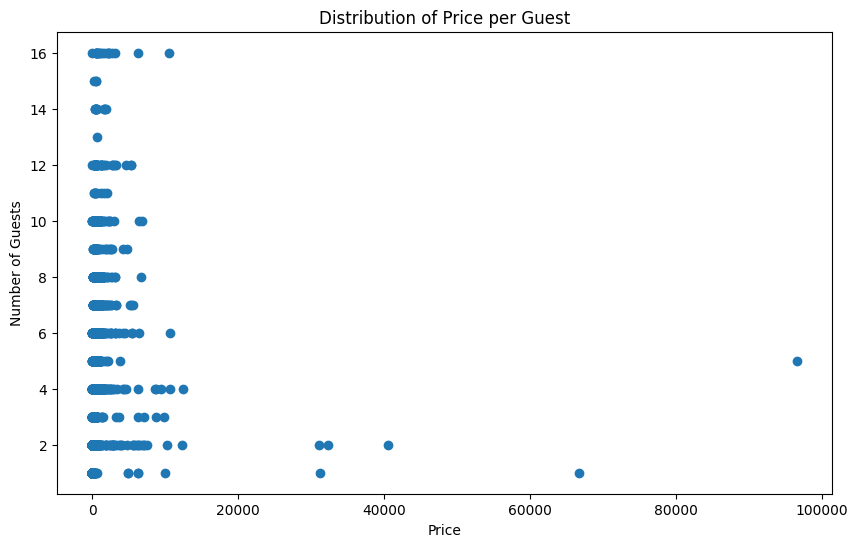

In [ ]:
# Exclude NaN values
df_price = df['price'].dropna()

# Plot the distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df["price"], df['numberOfGuests'], marker='o')
plt.xlabel('Price')
plt.ylabel('Number of Guests')
plt.title('Distribution of Price per Guest')

plt.show()

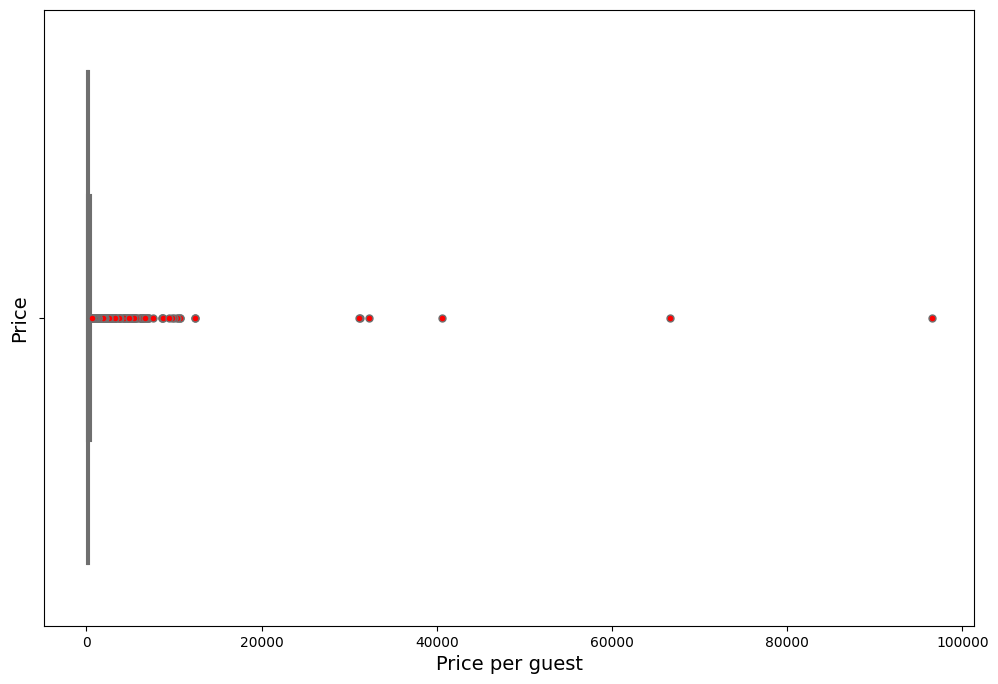

In [ ]:
plt.figure(figsize=(12, 8))

# Create the box plot
boxplot = sns.boxplot(x=df_price, color='skyblue', flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 5})


# Set the top 20 outliers to red
for i, artist in enumerate(boxplot.artists):
    if i > 0 and i <= 20:
        artist.set_facecolor('red')

plt.xlabel('Price per guest', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()

In [ ]:
# Identify extreme outliers
extreme_outliers = df[df['price_per_guest'] > 1500]

# Print the extreme outliers
print(extreme_outliers)

# Get the comments via "url" from df_rev_en for the extreme outliers
df_reviews_extreme_outliers = df_reviews[df_reviews['url'].isin(extreme_outliers['url'])]

# Print the comments for the extreme outliers -> appear very unserious
print(df_reviews_extreme_outliers['review_comments'])

                                                   url  \
3655              https://www.airbnb.com/rooms/9304886   
3660              https://www.airbnb.com/rooms/4268393   
3674             https://www.airbnb.com/rooms/23061033   
3678             https://www.airbnb.com/rooms/10080975   
3697             https://www.airbnb.com/rooms/44055791   
3700              https://www.airbnb.com/rooms/4361721   
3716   https://www.airbnb.com/rooms/665765208484121900   
3718             https://www.airbnb.com/rooms/24404337   
3723              https://www.airbnb.com/rooms/3226963   
3725             https://www.airbnb.com/rooms/40577782   
3726             https://www.airbnb.com/rooms/24134955   
3731             https://www.airbnb.com/rooms/24982623   
3747             https://www.airbnb.com/rooms/44313143   
12685            https://www.airbnb.com/rooms/13254774   
12686            https://www.airbnb.com/rooms/33472290   
12687            https://www.airbnb.com/rooms/41923555   
12688         

In [ ]:
# Remove the extreme outliers by price
print("Oirginal number of Airbnbs: ", len(df))
df = df[~df['url'].isin(extreme_outliers['url'])]
print("After filtering outliers by price: ", len(df))
print("Number of removed Airbnbs: ", len(extreme_outliers))

print("Oirginal number of Comments: ", len(df_reviews))
df_reviews = df_reviews[df_reviews['url'].isin(df['url'])]
print("After filtering outliers by price: ", len(df_reviews))

Oirginal number of Airbnbs:  13500
After filtering outliers by price:  13458
Number of removed Airbnbs:  42
Oirginal number of Comments:  686792
After filtering outliers by price:  685753


In [ ]:
# Identify extreme outliers
extreme_outliers2 = df[df['price_per_guest'] > 400]

# Get the comments via "url" from df_rev_en for the extreme outliers
df_reviews_extreme_outliers2 = df_reviews[df_reviews['url'].isin(extreme_outliers2['url'])]

# Remove the extreme outliers by price
print("Oirginal number of Airbnbs: ", len(df))
df_ex2 = df[~df['url'].isin(extreme_outliers2['url'])]
print("After filtering outliers by price: ", len(df_ex2))
print("Number of removed Airbnbs: ", len(extreme_outliers2))

print("Oirginal number of Comments: ", len(df_reviews))
df_reviews_ext2 = df_reviews[df_reviews['url'].isin(df_ex2['url'])]
print("After filtering outliers by price: ", len(df_reviews_ext2))
print(len(df_reviews_ext2)- len(df_reviews))

Oirginal number of Airbnbs:  13458
After filtering outliers by price:  13378
Number of removed Airbnbs:  80
Oirginal number of Comments:  685753
After filtering outliers by price:  684383
-1370


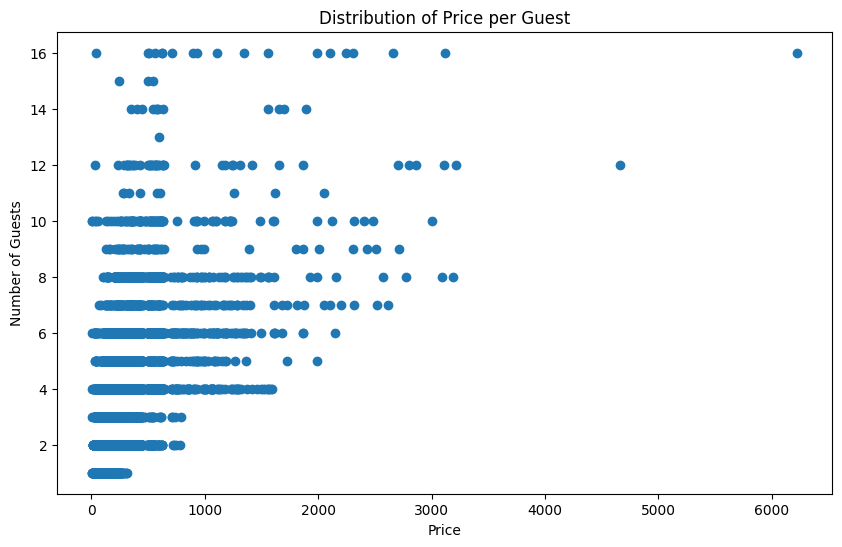

In [ ]:
# Plot the distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_ex2["price"], df_ex2['numberOfGuests'], marker='o')
plt.xlabel('Price')
plt.ylabel('Number of Guests')
plt.title('Distribution of Price per Guest')

plt.show()

In [ ]:
df_price.describe()

count    13432.000000
mean       290.751608
std       1270.904145
min         10.000000
25%        103.000000
50%        179.000000
75%        287.000000
max      96527.000000
Name: price, dtype: float64

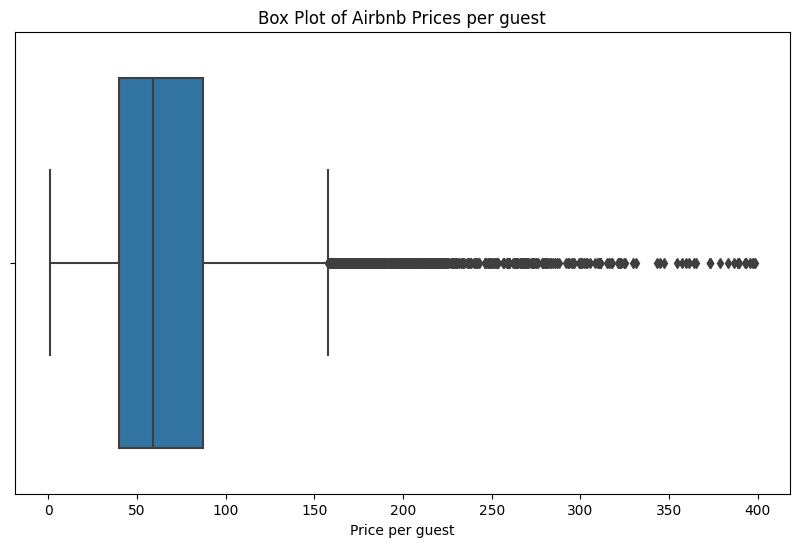

In [ ]:
# Exclude NaN values
df_price_per_guest_ex2 = df_ex2['price_per_guest'].dropna()

# Create a box plot for price
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_price_per_guest_ex2)
plt.title('Box Plot of Airbnb Prices per guest')
plt.xlabel('Price per guest')
plt.show()

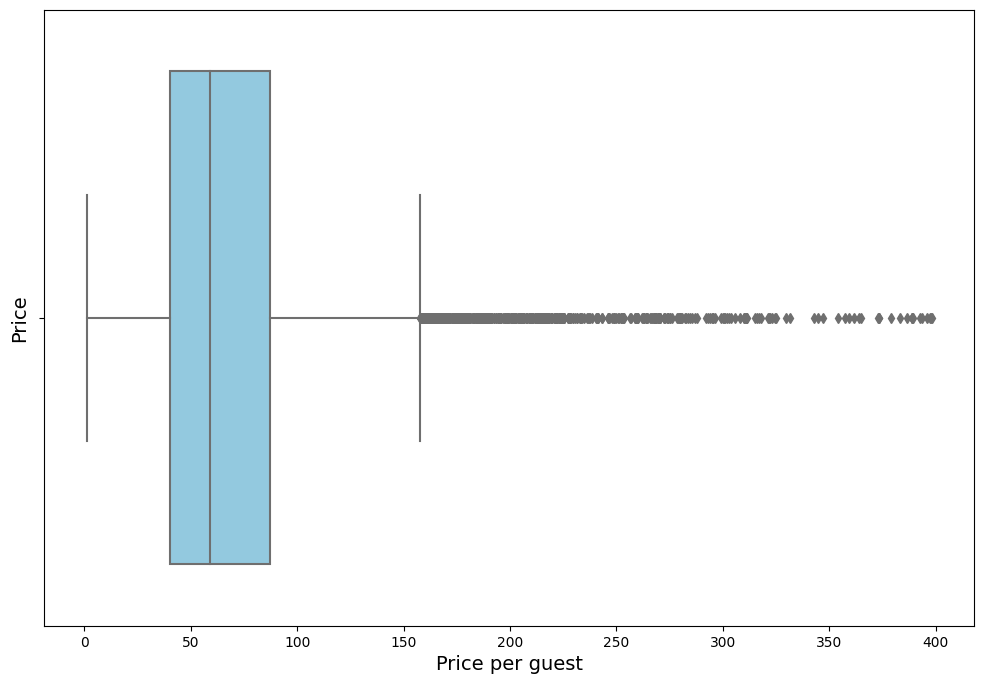

In [ ]:
plt.figure(figsize=(12, 8))

# Create the box plot
boxplot = sns.boxplot(x=df_price_per_guest_ex2, color='skyblue')

plt.xlabel('Price per guest', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()

By number of guests

In [ ]:
print(df['numberOfGuests'].describe())
print(df['numberOfGuests'].value_counts())

count    13458.000000
mean         3.319215
std          2.003427
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: numberOfGuests, dtype: float64
2     5161
4     3096
1     1430
3     1175
6     1141
5      675
8      312
7      208
10     110
9       57
12      47
16      20
14      13
11       9
15       3
13       1
Name: numberOfGuests, dtype: int64


### Save cleaned Dataframes to Drive

In [ ]:
# rename
df = df_ex2.copy()
df_reviews = df_reviews_ext2

In [ ]:
# Save dataframes at google drive
df_reviews.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_final.csv', index=False)
df.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_final.csv', index=False)

## Remove 0 and create binary

In [ ]:
# Delete rows with review_rating = 0
df_reviews_binary = df_reviews[df_reviews['review_rating'] != 0]

# Create a new column 'review_rating_new' with updated values
df_reviews_binary['review_rating'] = df_reviews_binary['review_rating'].replace({1: 'negative', 2: 'negative', 4: 'positive', 5: 'positive'})

# Remove rows with review_rating = 3
df_reviews_binary = df_reviews_binary[df_reviews['review_rating'] != 3]

# Print the modified DataFrame
print(len(df_reviews_binary))

<ipython-input-48-c975bcabc05f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews_binary['review_rating'] = df_reviews_binary['review_rating'].replace({1: 'negative', 2: 'negative', 4: 'positive', 5: 'positive'})
<ipython-input-48-c975bcabc05f>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reviews_binary = df_reviews_binary[df_reviews['review_rating'] != 3]


661147


In [ ]:
# Extract the URLs from df_reviews_binary
review_urls = df_reviews_binary['url'].unique()

# Keep only the rows in df with URLs present in df_reviews_binary
df_binary = df[df['url'].isin(review_urls)]

In [ ]:
# df_binary.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_final_binary.csv', index=False)
# df_reviews_binary.to_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_final_binary.csv', index=False)

## EDA

In [4]:
# Get saved df
df_reviews = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_final.csv')
df = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_final.csv')

df_bi = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_final_binary.csv')
df_reviews_bi = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_final_binary.csv')

In [ ]:
print(len(df_reviews), len(df))
print(len(df_reviews_bi), len(df_bi))

684383 13378
660645 13363


### Reviews

Review per Airbnb

In [ ]:
# Group by 'url' and count the number of reviews for each Airbnb
review_counts = df_reviews_bi.groupby('url').size()

# get summary statistics
print(review_counts.describe())

count    13363.000000
mean        49.438375
std         68.426340
min          1.000000
25%         10.000000
50%         25.000000
75%         60.000000
max       1039.000000
dtype: float64


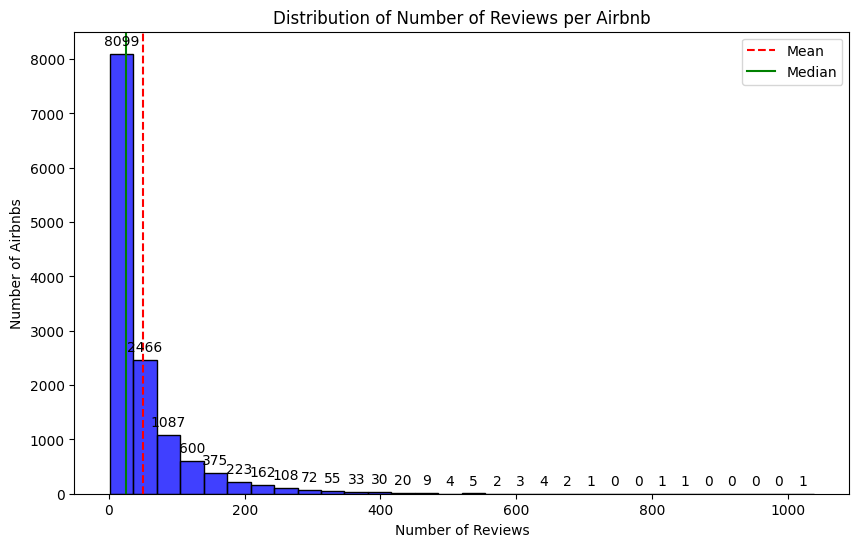

In [ ]:
# Calculate mean and median
mean_count = np.mean(review_counts)
median_count = np.median(review_counts)

# Plot the distribution
plt.figure(figsize=(10,6))
histplot = sns.histplot(review_counts, bins=30, kde=False, color='blue')

# Add count numbers on top of each bar
for p in histplot.patches:
    histplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Add lines and labels for mean and median
plt.axvline(mean_count, color='red', linestyle='--')
plt.axvline(median_count, color='green', linestyle='-')
plt.legend({'Mean':mean_count,'Median':median_count})

plt.title('Distribution of Number of Reviews per Airbnb')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Airbnbs')
plt.show()

Words per Comment

count    660645.000000
mean         43.939305
std          44.282150
min           0.000000
25%          16.000000
50%          32.000000
75%          57.000000
max        1012.000000
Name: review_length, dtype: float64


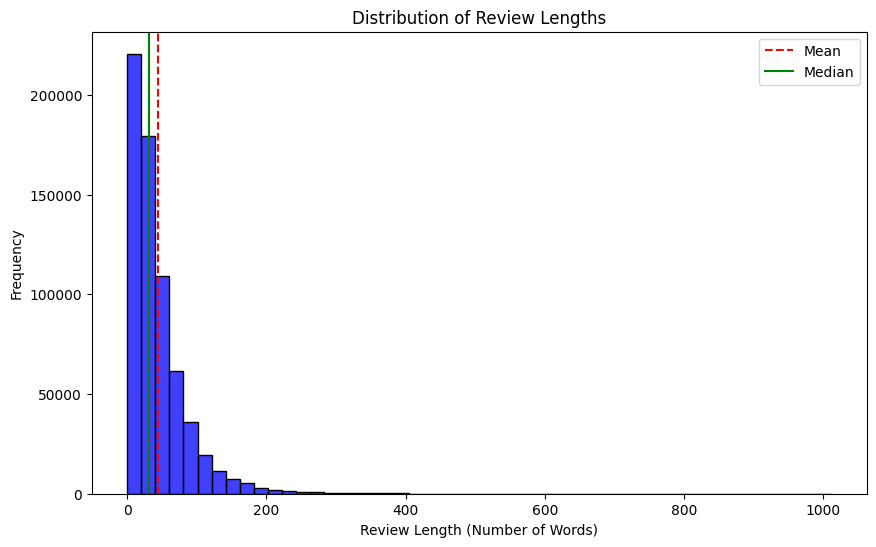

In [ ]:
# Add a new column 'review_length' to df_reviews indicating the number of words in each review
df_reviews_bi['review_length'] = df_reviews_bi['review_comments'].apply(lambda x: len(x.split()))

review_length_stats = df_reviews_bi['review_length'].describe()
print(review_length_stats)

# Extract 'review_length' from 'df_reviews_filtered' and store it into 'review_lengths'
review_lengths = df_reviews_bi['review_length']

# Calculate mean and median
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)

# Plot the distribution
plt.figure(figsize=(10,6))
histplot = sns.histplot(review_lengths, bins=50, kde=False, color='blue', edgecolor='black')

# Add lines and labels for mean and median
plt.axvline(mean_length, color='red', linestyle='--')
plt.axvline(median_length, color='green', linestyle='-')
plt.legend({'Mean':mean_length,'Median':median_length})

plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()


### Review Rating

In [ ]:
# Get count of review rating
print(df_reviews['review_rating'].value_counts())

5.0    559774
4.0     94738
3.0     18612
0.0      4624
2.0      3895
1.0      2740
Name: review_rating, dtype: int64


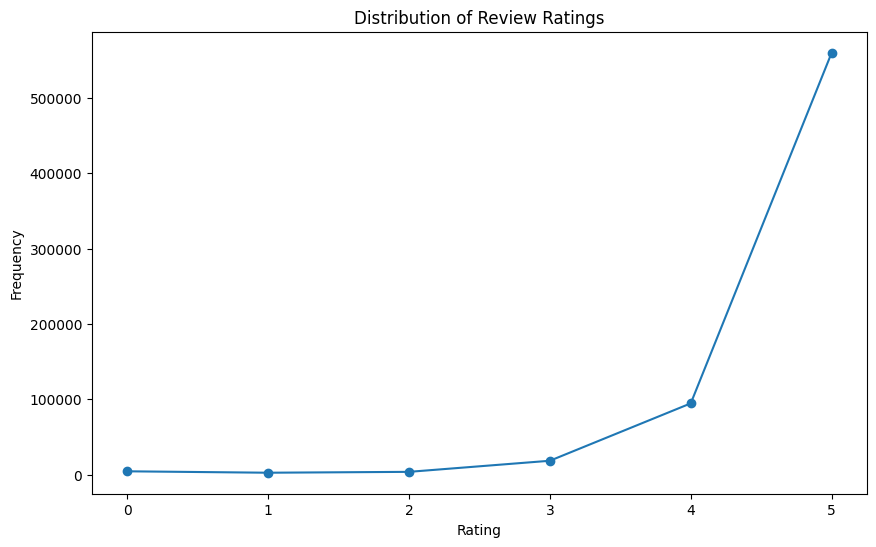

In [ ]:
# Check the frequency of each unique value in the 'review_rating' column
rating_counts = df_reviews['review_rating'].value_counts()

# Sort the values in ascending order
rating_counts = rating_counts.sort_index()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(rating_counts.index, rating_counts.values, marker='o')

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Review Ratings')

plt.show()

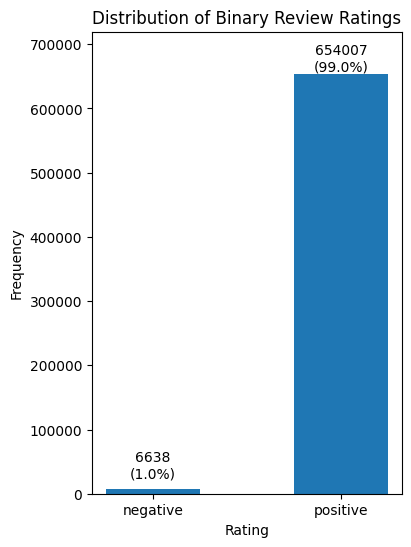

In [ ]:
# Check the frequency of each unique value in the 'review_rating' column
rating_counts2 = df_reviews_bi['review_rating'].value_counts()

# Sort the values in ascending order
rating_counts2 = rating_counts2.sort_index()

total_reviews2 = len(df_reviews_bi)
percentages2 = (rating_counts2 / total_reviews2) * 100

plt.figure(figsize=(4, 6))
plt.bar(rating_counts2.index, rating_counts2.values, align='center',  width=0.5)

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Binary Review Ratings')

# Add text annotations for both numbers and percentages
for i, value in enumerate(rating_counts2.values):
    if i == len(rating_counts2.values) - 1:
        plt.text(i, value, f"{value}\n({percentages2[i]:.1f}%)", ha='center', va='bottom')
    else:
        plt.text(i, value + 0.02* max(rating_counts2.values), f"{value}\n({percentages2[i]:.1f}%)", ha='center', va='bottom')

plt.ylim(0, max(rating_counts2.values) * 1.1)  # Adjust y-axis limits

plt.show()

### Super Host

In [ ]:
# Get count of Superhosts vs non-Superhosts
superhost_counts = df_bi['isHostedBySuperhost'].value_counts()
print(superhost_counts)

False    8528
True     4835
Name: isHostedBySuperhost, dtype: int64


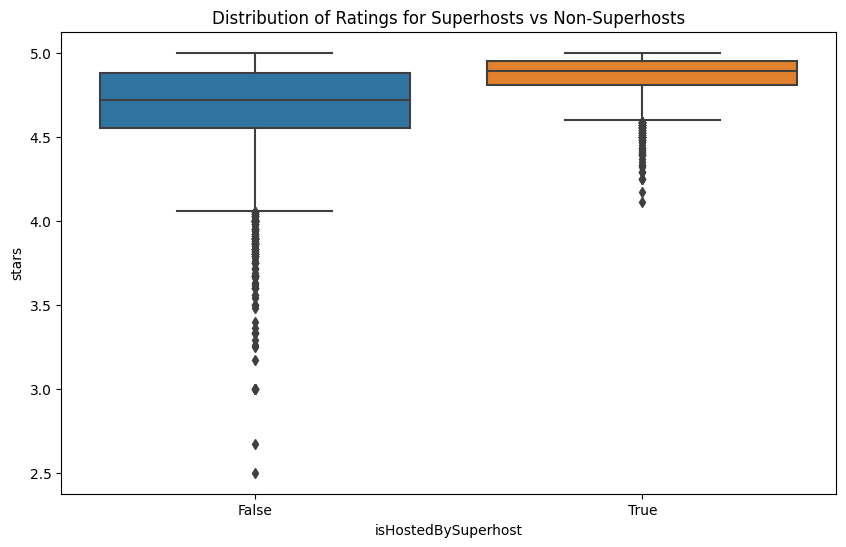

In [ ]:
# Comparing super host and non with stars
# Boxplot of ratings grouped by Superhost status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='isHostedBySuperhost', y='stars')
plt.title('Distribution of Ratings for Superhosts vs Non-Superhosts')
plt.show()

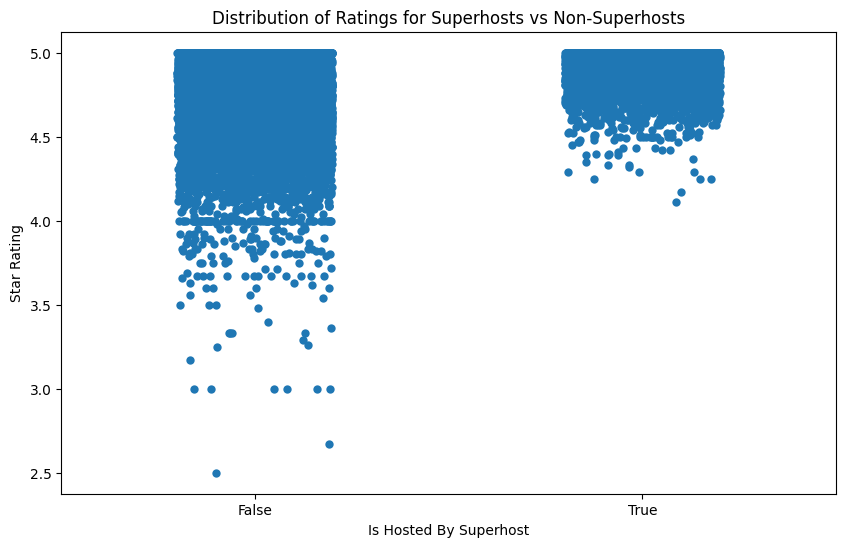

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='isHostedBySuperhost', y='stars', jitter=0.2, size=6)
plt.title('Distribution of Ratings for Superhosts vs Non-Superhosts')
plt.xlabel('Is Hosted By Superhost')
plt.ylabel('Star Rating')
plt.show()

### Price

In [ ]:
# Get summary statistics for price
print(df_binary['price'].describe())

count    13298.000000
mean       234.460319
std        243.541553
min         10.000000
25%        103.000000
50%        176.000000
75%        284.000000
max       6219.000000
Name: price, dtype: float64


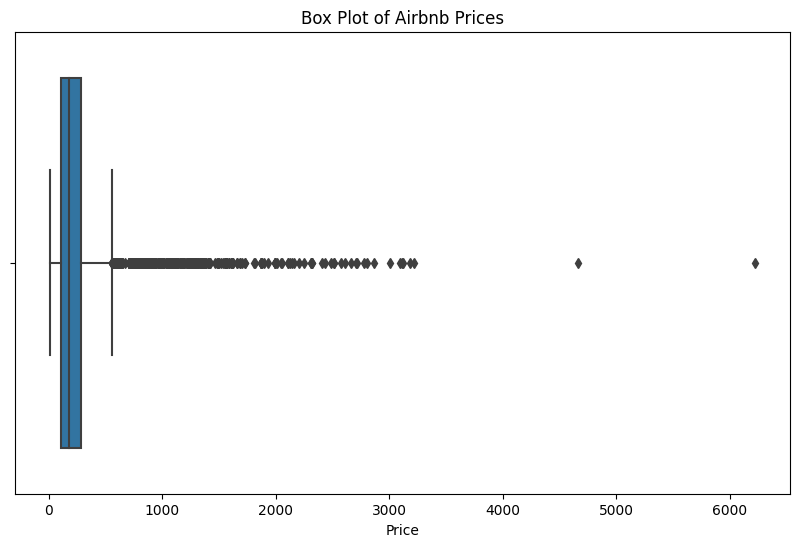

In [ ]:
# Exclude NaN values
df_price = df_bi['price'].dropna()

# Create a box plot for price
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_price)
plt.title('Box Plot of Airbnb Prices')
plt.xlabel('Price')
plt.show()

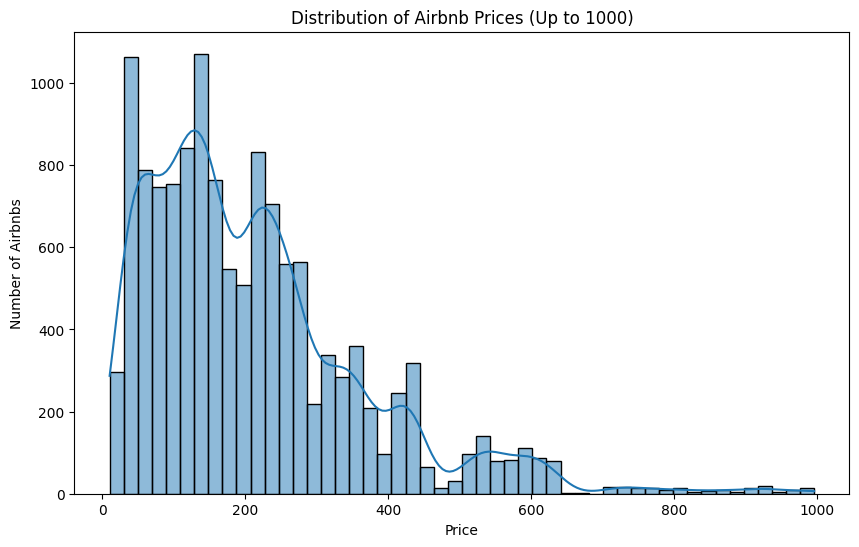

In [ ]:
# Exclude NaN values and prices over 1000
df_price = df_bi[df_bi['price'] <= 1000]['price'].dropna()

# Create a distribution plot for price
plt.figure(figsize=(10, 6))
sns.histplot(df_price, bins=50, kde=True)
plt.title('Distribution of Airbnb Prices (Up to 1000)')
plt.xlabel('Price')
plt.ylabel('Number of Airbnbs')
plt.show()
